In [1]:
import math 
import numpy as np
import pandas as pd
from sklearn import neighbors
import os
import matplotlib.pyplot as plt
import os.path
import pickle
from PIL import Image,ImageDraw
import face_recognition
from face_recognition.face_recognition_cli import image_files_in_folder
ALLOWED_EXTENSIONS = {'png', 'jpg', 'jpeg'}

In [2]:
def get_train_values(train_dir,model_save_path=None,n_neighbors=None,knn_algo="ball_tree",verbose="False"):
    X = []
    y = []

    for class_dir in os.listdir(train_dir):
        if not os.path.isdir(os.path.join(train_dir, class_dir)):
            continue
            
        for img_path in image_files_in_folder(os.path.join(train_dir, class_dir)):
            image = face_recognition.load_image_file(img_path)
            face_bounding_boxes = face_recognition.face_locations(image)

            if len(face_bounding_boxes) != 1:
                if verbose:
                    print("Image {} not suitable for training: {}".format(img_path, "Didn't find a face" if len(face_bounding_boxes) < 1 else "Found more than one face"))
            else:
                X.append(face_recognition.face_encodings(image, known_face_locations=face_bounding_boxes)[0])
                y.append(class_dir)
    if n_neighbors is None:
        n_neighbors = int(round(math.sqrt(len(X))))
        if verbose:
            print("Chose n_neighbors automatically:", n_neighbors)
            
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=knn_algo, weights='distance')
    knn_clf.fit(X, y)

    if model_save_path is not None:
        with open(model_save_path, 'wb') as f:
            pickle.dump(knn_clf, f)

    return X,y

In [3]:
def get_test_values(X_img_path, knn_clf=None, model_path=None, distance_threshold=0.6):
    if not os.path.isfile(X_img_path) or os.path.splitext(X_img_path)[1][1:] not in ALLOWED_EXTENSIONS:
        raise Exception("Invalid image path: {}".format(X_img_path))

    if knn_clf is None and model_path is None:
        raise Exception("Must supply knn classifier either thourgh knn_clf or model_path")

    if knn_clf is None:
        with open(model_path, 'rb') as f:
            knn_clf = pickle.load(f)
            
    X_img = face_recognition.load_image_file(X_img_path)
    X_face_locations = face_recognition.face_locations(X_img)
    

    if len(X_face_locations) == 0:
        return []

    
    faces_encodings = face_recognition.face_encodings(X_img, known_face_locations=X_face_locations)
    closest_distances = knn_clf.kneighbors(faces_encodings, n_neighbors=1)
    are_matches = [closest_distances[0][i][0] <= distance_threshold for i in range(len(X_face_locations))]

    #return [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]
    return faces_encodings

In [4]:
x,y=get_train_values("images/train/", model_save_path="trained_knn_model.csv",n_neighbors=2)

In [6]:
x_test=[]
for image_file in os.listdir("images/test/"):
        full_file_path = os.path.join("images/test/", image_file)

        #print("Looking for faces in {}".format(image_file))

        # Find all people in the image using a trained classifier model
        # Note: You can pass in either a classifier file name or a classifier model instance
        encodings=get_test_values(full_file_path, model_path="trained_knn_model.csv")
        x_test.append(encodings[0])

In [7]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=2, algorithm="ball_tree", weights='distance')
knn_clf.fit(x, y)

KNeighborsClassifier(algorithm='ball_tree', n_neighbors=2, weights='distance')

In [8]:
y_pred=knn_clf.predict(x_test)

In [9]:
y_pred

array(['Adrian_Annus', 'Adrian_Annus', 'Adrian_Annus', 'Adrian_Annus',
       'Adrian_Annus', 'Agnes_Bucker', 'Agnes_Bucker', 'Agnes_Bucker',
       'Agnes_Bucker', 'Agnes_Bucker', 'Agnes_Bucker', 'Agnes_Bucker',
       'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy',
       'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy',
       'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy',
       'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy',
       'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy',
       'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy', 'Ally_sheedy',
       'Ally_sheedy', 'Ally_sheedy'], dtype='<U12')

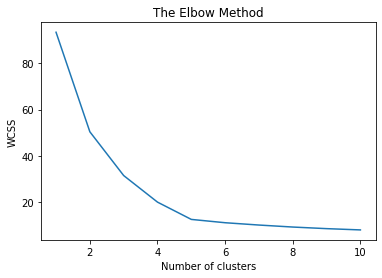

In [10]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
from sklearn.cluster import KMeans
k=KMeans(n_clusters=3)
k.fit(x,y)

KMeans(n_clusters=3)

In [12]:
predict=k.predict(x_test)

In [13]:
predict

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
dataframe=pd.DataFrame(x)

In [15]:
columns=[f'X{x}' for x in range(0,128)]

In [16]:
dataframe.columns=columns

In [17]:
dataframe["target"]=y

In [18]:
dataframe["target"]=dataframe["target"].map({'Adrian_Annus':0,'Agnes_Bucker':1,'Ally_sheedy':2})

In [19]:
cluster0=dataframe.loc[dataframe['target']==0]
cluster1=dataframe.loc[dataframe['target']==1]
cluster2=dataframe.loc[dataframe['target']==2]

In [20]:
cluster0.shape

(107, 129)

In [21]:
cluster1.shape

(140, 129)

In [22]:
cluster2.shape

(130, 129)

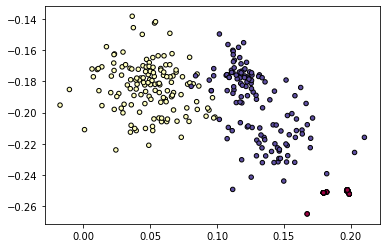

In [23]:
plt.scatter(dataframe['X1'],dataframe['X32'],c=dataframe.target.astype(int),s=20, cmap='Spectral',edgecolors="black")

In [53]:
cluster0_sample=cluster0.sample(n=50,replace=False)
cluster1_sample=cluster1.sample(n=50,replace=False)
cluster2_sample=cluster2.sample(n=50,replace=False)

In [54]:
dataset=cluster0_sample
dataset=dataset.append(cluster1_sample)
dataset=dataset.append(cluster2_sample)

In [55]:
x=dataset.iloc[:,:-1].values
y=dataset.iloc[:,-1].values

In [56]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [57]:
import umap as u

In [58]:
standard_embedding = u.UMAP(random_state=42).fit_transform(x)

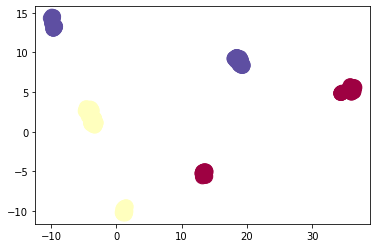

In [59]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=dataset.target.astype(int), s=200, cmap='Spectral');

In [60]:
test=u.UMAP(random_state=31).fit_transform(x_test)

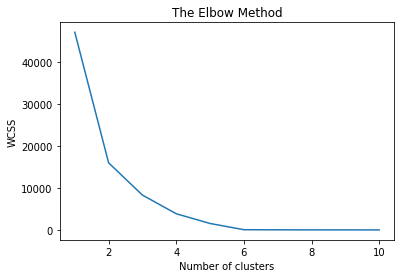

In [61]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(standard_embedding)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [74]:
from sklearn.cluster import KMeans
k=KMeans()
k.fit(standard_embedding,y)

KMeans()

In [75]:
predict2=k.predict(test)

In [76]:
predict2

array([5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])